In [1]:
# Setup

library(rjags)
library(runjags)
library(R2jags)
library(tidybayes)
library(dplyr)
library(coda)
library(rstanarm)
library(plotrix)
library(dupiR)

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Rcpp

This is rstanarm version 2.21.1

- See https://mc-stan.org/rstanarm/articles/priors for changes to default priors!

- Default priors may change, so it's safest to specify priors, even if equivalent to the defaults.

- For execution on a local, multicore CPU with excess RAM we recommend calling

  options(mc.cores = parallel::detectCores())



         
           Neg  Pos
  Placebo 6722   88
  Vaccine 6779   21

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Thu Jul  8 10:02:46 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 13610
   Unobserved stochastic nodes: 2
   Total graph size: 27226
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 20000
-------------------------------------------------| 20000
************************************************** 100%
. . . . Updating 0
. Deleting model
All chains have finished
Note: the model did not requ

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.01028250,0.012878050,0.01558170,0.012914932,0.0013541345,NA,6.826077e-06,0.5,39353,-0.0027379095,1.000056
theta[2],0.00184588,0.003039975,0.00443894,0.003089602,0.0006741206,NA,3.378602e-06,0.5,39811,0.0007716574,1.000135


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....



JAGS model summary statistics from 80000 samples (chains = 4; adapt+burnin = 5000):
                                                                           
           Lower95    Median   Upper95      Mean         SD Mode      MCerr
theta[1]  0.010286  0.012879  0.015588  0.012921  0.0013603   -- 4.8093e-06
theta[2] 0.0018219 0.0030421 0.0044179 0.0030917 0.00067258   -- 2.3637e-06
                                        
         MC%ofSD SSeff      AC.10   psrf
theta[1]     0.4 80000 -0.0027379 1.0001
theta[2]     0.4 80963 0.00077166      1

Total time taken: 40.5 seconds


png 
  2

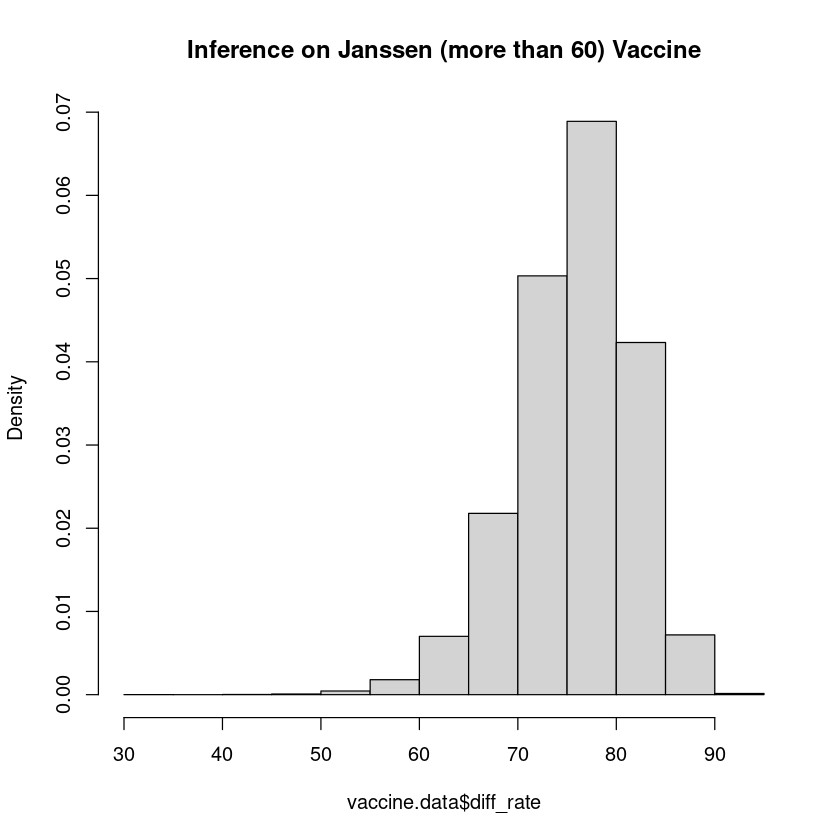

In [30]:
### more than 60


tot_vaccine <- 6800
tot_placebo <- 6810
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 21
pos_placebo <- 88
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
vaccine.tb <- tibble::tibble(tested = tested, patient=patient)
table(vaccine.tb[[2]], vaccine.tb[[1]])

dataList = list(
    tested = ifelse(vaccine.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(vaccine.tb$patient)),
    Ntot = nrow(vaccine.tb) ,
    Nclass = nlevels(factor(vaccine.tb$patient))
)

modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(0.010101 , 1)    
    }
  }"
writeLines(modelString , con="jags_Vaccine_model.txt")

vaccine_chains <- run.jags(modelString ,
                          sample = 20000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

summary(vaccine_chains)
add.summary(vaccine_chains)


### Efficacy

vaccine_res    <- tidybayes::tidy_draws(vaccine_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

vaccine.mcmc <- as.mcmc(vaccine_res)
vaccine.data <- as.data.frame(vaccine.mcmc)

hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Janssen (more than 60) Vaccine')

tb = bayestestR::describe_posterior(vaccine.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")


pdf(file='Janssen(more than 60)')
hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Janssen (more than 60) Vaccine',xlab='Efficacy')
abline(v=tb$CI_low,lty=2)
abline(v=tb$CI_high,lty=2)
dev.off()

In [32]:
pdf(file='Janssen.Jags(more than 60)')
plot(vaccine.mcmc[,c('Vaccine','Placebo','diff_rate')],col='forestgreen')
dev.off()

png 
  2

In [ ]:
pdf(file='Pfizer.Jags(overall)')
plot(vaccine.mcmc[,c('Vaccine','Placebo','diff_rate')],col='forestgreen')
dev.off()